### Authors : Kanvaly FADIGA & Mohamed TRAORE

In [52]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("data/custom3.css").read()
    return HTML(styles)
css_styling()

# Introduction 

In this work , we are trying to predict credit default risk. We are dealing with historical credit clients informations and are willing to predict whether or not a client will reimbursed his credit . This is a standard supervised classification task . First of all , we are going to analyze and clean data  . Then , extract relevelant pattern in data . Choose /Train models and optimize the most promising . And at the end , Stacking them  for having a strong predictor . 

### Importing Packages and loading data

In [3]:
import numpy as np 
import pandas as pd 
from scipy.stats import randint

import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import set_option
plt.style.use('ggplot') 



In [4]:
data=pd.read_csv('./data/raw/CreditTraining.csv')
data.sample(8)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
5168,2311,0,Non Existing Client,03/05/1983,31/07/2011,NP_Client,University,Married,0.0,15,30,1.0,C,12/08/2011,Sales,Owned,1,NaN,B
4648,9257,0,Non Existing Client,10/10/1989,05/04/2012,NP_Client,University,Single,0.0,10,36,3.0,C,10/04/2012,Sales,Owned,1,NaN,B
1884,8752,0,Existing Client,14/12/1974,13/03/2003,NP_Client,University,Married,0.0,30,48,20.0,G,27/03/2012,Branch,Owned,1,NaN,B
4299,2796,0,Existing Client,16/07/1973,13/03/2008,NP_Client,Master/PhD,Married,4.0,9,18,5.0,G,08/09/2011,Sales,Owned,1,NaN,C
2438,7125,0,Existing Client,15/12/1982,07/12/2011,NP_Client,University,Single,0.0,28,240,5.0,G,04/01/2012,Branch,Owned,1,NaN,B
4034,8453,0,Non Existing Client,22/09/1949,13/03/2012,NP_Client,University,Married,0.0,2,18,2.0,C,14/03/2012,Sales,Owned,2,NaN,B
2307,2755,0,Existing Client,01/05/1948,22/10/2006,NP_Client,University,Married,2.0,10,36,3.0,G,18/09/2011,Sales,Owned,1,NaN,C
252,5196,0,Existing Client,20/09/1954,09/04/2009,P_Client,University,Married,3.0,10,"143,844",10.0,G,21/12/2011,Branch,Owned,1,NaN,G


### Explanatory Data Analysis 

####  Data presentation 

* The dataset includes 5380 uniques clients with 19 differents informations . 

* There are many (13) categorical variables ( Custuomer_Type , Education_level , Marital_status ...) .  

* Many of the explanatory variables are categorical. From then on we understand that one of the determining factors will be the encoding of these variable ,we will discuss this part in the feature engineering section.

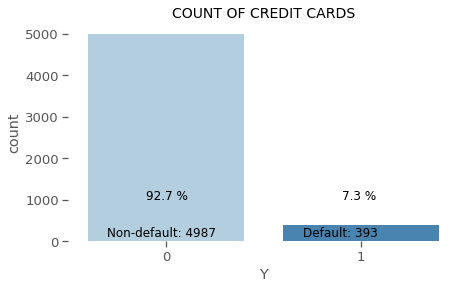

In [5]:
# The frequency of defaults
yes = data["Y"].sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)

import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('Y',data=data, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 100), xytext=(-0.3, 100), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 100), xytext=(0.7, 100), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 1000), xytext=(-0.1, 1000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 1000), xytext=(0.9, 1000), size=12)
plt.title('COUNT OF CREDIT CARDS', size=14)
#Removing the frame
plt.box(False);

* There is only 393 clients ( on 5380) who defaulted theirs credits which represent 7.3% of data . We are dealing with **unbalanced data** .

### Cleaning data and Features Engineering

In [4]:
from datetime import datetime

date2year = lambda d : datetime.strptime(d, "%d/%m/%Y").year
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d/%m/%Y")
    d2 = datetime.strptime(d2, "%d/%m/%Y")
    return abs((d2 - d1).days)

## Join_age: age that client had taking credit
data["join_age"] = data.Customer_Open_Date.apply(date2year)-data.BirthDate.apply(date2year)

##  sub_delay : subscription data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAdIAAAEiCAYAAABN8lMvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nO3deZyO1f/H8dex72skIoRvZIlCEaG0SPWtdEpaKf2KirZvJZVKtGuP8q206ST5FmlDKYnsKSJbZRvblHWYcf3+uK6Zbrd7xj2umXtmeD8fj+sxc59zrnOdczH35z7nOtd9Gc/zEBERkYNTKK8bICIiUpApkIqIiISgQCoiIhKCAqmIiEgICqQiIiIhKJCKiIiEoEAqIiISggKpFEjGmCONMc8aY5YZY1KMMauNMRONMV2iyrU2xnxsjNkclFtsjHnAGFMiqpxnjOkW4zhvGGPGR7z+Oih7RVS5a4wx2yL28bLaDtC3y40x040x24wx240xM2Icr3YmdY8Le96MMSsj6tsZnLM7jTEmjuN7xpizI85JelqaMSbZGDPLGDPYGFM1ql0PGmMWRp3jzLaVWfTPGGOuC87fVmPM38aYOcaYu4wx5aLKVjXG7DLG/G6M2e+98CDPwzZjzK/GmNeMMU1j1HmdMWZuUO4vY8wCY8wjWf2bSf6nQCoFjjGmNjAHOAu4B2gKnAFMAF6JKHc+8C2wKchvAAwCegNfGGOKHWQTdgGPGGOKZ5J/K3BUxLYD6BeVllnfHgNeB/4HnAg0B8YCI40xQ2PscnZUvddkUXdt4jhvgYeC+hoCTwKP4p+3Ax3/KGByRP6OIO1ooDUwDDgfWGiMaZhJUy+KqOv4IO3iiLSWmfUReAt4HvgUOD3o40CgY1BvpGuAT/D/Pc/KpL7snocmQH+gKjDbGHNZegFjTE/gOfxzfQJwCvAwUCqL/khB4HmeNm0FasN/k1wDlImRVzH4WQrYAIyLUaYFsBe4MyLNA7rFKPsGMD7i9ddB2jrgtoj0a4BtmbR3G3BNHP1qFbSjX4y8fkFeq+B17eD1STl53oLfVwJ3ROXPBj6MeH3A42d2ToAywBLgm4i0B4GFMcoeERynQxz9s0HZizLJrxD1ejFwHn6gHROjfKjzALwLJKcfFxgHvJ3bfx/aEr9pRCoFijGmEv6n/xc8z9sWne953pbg17Pw34Qfj1FmDjAJuPwgm7ENf6QywBhT4SDriKVHUPdLMfJeBrYD3Q+m4myct+j9jDGmA/6IbM/BHDvGsbbhj8raG2Oq5ESdgR7AEs/zxmZy3OT0340x7YDKwGfA28B5WbXlIM/Dk0B5/FE/+B++Whlj6sa5vxQQCqRS0NQDDLDoAOUaBD8zK/cL8K8Q7RiBP2V8d4g6ojUAlnuetzs6w/O8FGAZ+7d5anC9LX1rl0nd8Z63dIONf803BZgS7PtcjHLRx99mjCkfR/2/BD/rxNmeeNTHH2XG4zrgfc/z9nietwKYAVwVo1y85yGW9D6mB85B+P9nlhljlhpj3jbGXGWMKRpnfZJPKZBKQWMOXCTueg76iQ2e56UCA4BbjDFH51CbIOs2xWrz5fjX29K3WVnsmx1PB/Wdhh9ABnme932MctHHPwHYGkf96e3JyadmxNXHYNFRN/zrqeneAnrFKB7veciqPf61A89b63neKfjXUYcF+cOBmcYYXSctwBRIpaBZiv/GlNlClXRLgp+NMslvGNSVbiv+NFy0CsBfsSrwPO8D4Cf8kUZOWALUi7WIKUiry75tBvjT87zfIradmdQd73lLtymobzr+Qp87jDEdY5SLPv5vnuftjaP+RkF7VsbZnngsIb7+XY5/DX2aMSbVGJOKP3Xe0BjTNqpsvOchlvT/e8sjEz3PW+h53oue5/UAOuMHahtnnZIPKZBKgeJ53mbgc6CvMaZMdH7ENcsv8KfR7oxRpgX+is53IpJ/xV8lG1muMNAsyMvMXcDV/LO6NIz3gNLAjTHybgry3j2YirNx3mLtuwV4AXgm8taPgxUc///wFxttCFtfhHeB+saY6NW56cdN72Mv/P5Ej6QnEHtUChzUebgD/0PYV1mUSZ/+3e/fRAoOBVIpiG7CnxabZYy5xBjzL2PMccaYG4EFAJ7nbQeuB841xvzXGNPcGFMruB3hY+A74NmIOp8Gehpj+hhjGhhjTsC/Dlop+BmT53nf4C9Y6Ru2U57n/QA8BTxmjPlP0I76xpi7gKHAY57nzQxxiAOetyy8iH999pKo9MrGmGpRW8mIfBOR/i/j3w87HX/0f1OIvsTigNHAO8aYgcaYlsaYY4wxZxtjJgD/Du7tPAl4NRgZZmz407vWGFM2i2Mc6DzUMcacY4z5GH/6+P88z/sLwBjzctCutkG7TgZG4d8i9EVOnghJsLxeNqxN28Fs+PfsPY8/bZaCf1vHROCcqHKnAOOBLUG5X/FvtSgRo87u+NcY/8ZfYTkBaBpV5mv8la+RaY2BNELe/hJR/krgB/w32B34C2GujCpTm2ze/hLveSPGbR9B+gj8EVShiOPH2q4Lyl8TkbYXf3Q2B/9ezKpRdT9IyNtfgvIG/z7PGcF5/xuYiz9zUBZ/odCSTPYtHZzv3iHOww78KeaRQLOo/S4K/i+uDs792uB1m7z+e9IWbjPBP7CIiIgcBE3tioiIhKBAKiIiEoICqYiISAgKpCIiIiEokIqIiISgQCoiIhKCAqmIiEgICqQiIiIhKJCKiIiEoEAqIiISggKpiIhICEUSdSBr7Rv4j5uK1N85NyyizLnAk0AdYCFwo3Pux4j8asArwJlAMvCsc+6xqOPcA9yM/xzJL4DezrmkHO+QiIgIiR+ROvynT6RvGY+nstYeB4zFf6xQC+B7YKK1tmLE/u/jP36pDdAHuM9ae1VEHdcC9wZ5bfCD6Xu52B8RETnMJWxEGtjpnFuXSV5v4Afn3BAAa+2twAVAD+AFa21ToD1wrHNuOTDPWvsMcAt+8AV/JPq0c+6joI6ewDJrbWPn3MJc65WIiBy2Eh1Iz7fWbsB/Dt97wBPOudQgrxXwZXpB55xnrZ0MtMZ/Kn0rYGUQRNNNAu611hbDfw5hM6B/RB3LrbUrgzr2CaTW2gr4I9Zoyc655FC9FBGRw0YiA+mn+E+vXw2cCDyB/6Dde4P8qkD0tcwN+MExq/zCQGX8QFookzJVY7SnH/BAdGK3bt0O3JNsGD93RY7WJ5KVrs3r5HUTRA5VJrOMhAVS55yLePmTtTYNeNlaO8A555FFIwNh86MNA96IThwzZkyytTYnR6R6crokUnb/DkQkpERP7UaaA5QGjsAfNa5n/5FjFf4ZYWaWnwZswn8D2RuUWZRJHRmC6VtN4YqISCh5eR9pY2AHsDF4PRPoGFWmIzAjIr+2tTZy7qoTMM85t9s5lwLMj6wjKFs7og4REZEclcj7SJ/Gv31lPf7tLU8Dw4NpXfBvhZlvrf0P8DFwA1AGeAfAObfAWjsVGGmt7Y8fIPsDfSMO8wIwzFo7F1gJPANM0YpdERHJLYkckTYCxgO/Ao8Bw4F70jOdc4uBi4FrgHlAO6CLc25LRB2XAluB6fhfzPCoc25URB3/BYYEedODst1zrUciInLYM56ntTC5afzcFTrBkjBdm9fRYiORBNN37YqIiISgQCoiIhKCAqmIiEgICqQiIiIhKJCKiIiEoEAqIiISggKpiIhICAqkIiIiISiQioiIhKBAKiIiEoICqYiISAgKpCIiIiEokIqIiISgQCoiIhKCAqmIiEgICqQiIiIhKJCKiIiEoEAqIiISggKpiIhICAqkIiIiISiQioiIhKBAKiIiEoICqYiISAgKpCIiIiEokIqIiISgQCoiIhKCAqmIiEgICqQiIiIhKJCKiIiEoEAqIiISQpG8OrC19iPg30BH59zXQVpr4EWgMbAcuN05NzFinzLAC8BFwB7gDeAu51xaRJlrgfuBasAPwPXOud8S0CURETkM5cmI1Fp7JVA6Kq0yMBGYBrQA3gI+stbWjyj2ItASOAO4BOgODIiooxMwHHgkKJcETLDW5tkHBhERObQlPJBaa2vgB7rrorJ6AH8D/ZxzvzjnhgAzgRuC/SoGZfo652Y65yYD9wF9rLXp/egLvOecG+mcWwj0BGoCZ+d2v0RE5PCUFyO114BHnXO/W2sj01sBU5xzXkTaJPzRJ8CJgAdMjcqvCtQBlgV1ZIxQnXPbrbUzgNbA+MiDWWsrABVitC/ZOZd8EP0SEZHDUEIDqbX2BqCoc254jOyqwNyotA1Benr+5sjroUF+et6y4GdSFnVE6gc8EJ3YrVu3rLogkt95By4iIgfBZJaRsEBqra2FH7jaZFIk00ZmkR/mTWMY/mKlfYwZMybZWpuTI1K9sUkiHejvSERyWCJHpC3wV9L+FjWlO8la+wawnv1HjlX4Z4S5HqhkrS0cMSpNL58U8TNWHb9GNyaYvtUUroiIhJLIxUaTgKbACREb+IuO7sdfWNQhap9OwIzg9zn4n7bbReUnASuC1zOBjumZ1tpS+NdHZyAiIpILjOfl3cyjtdYjuI80uP1lKTAK/xaW84FBQBPn3NKg/CigOdAL//aZt4HhzrmHgvzT8W+h+T/84DkwKN/YObcnkX1LN37uCk3tSsJ0bV5HU7siCZZvvtnIObcJ6II/4pwHXANclB5EAzfhj0wnAR8C7wODI+qYhB9E7wdm408ld82rICoiIoe+PB2RHg40IpVE0ohUJPHyzYhURESkIFIgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQlAgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQlAgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCSEIok8mLV2ENAdqAn8DXwF3O6cWxfknws8CdQBFgI3Oud+jNi/GvAKcCaQDDzrnHss6hj3ADcDFYAvgN7OuaRc7pqIiBym4h6RWmtrWWtNjHRjra0VZzWLgRuAhsB5QC3gzaCe44CxwCigBfA9MNFaWzFi//eB8kAboA9wn7X2qoi2XAvcG+S1wQ+m78XbRxERkezKzoh0BXAUED26qxTkFT5QBc65yKC20lr7OP8Eut7AD865IQDW2luBC4AewAvW2qZAe+BY59xyYJ619hngFvzgC/5I9Gnn3EdBHT2BZdbaxs65hdnoq4iISFyyE0j3G40GSgEp2T2wtbY8cDkwLUhqBXyZnu+c86y1k4HWwAtB/sogiKabBNxrrS0WtK8Z0D+ijuXW2pVBHfsEUmttBfwRa7Rk51xydvsjIiKHpwMGUmvt/cGvHnCHtXZbRHZhoC3wc7wHtNb2AIYDpYEZQJcgqyr7j3Y34AfHrPILA5XxA2mhTMpUjdGUfsAD0YndunWLpxsi+ZWX1w0QOURlNpiMa0R6ZUQl3YC0iLzd+NO6/8lGYz4GZuIvOBqEH1QvyaqREccPkx9tGPBGdOKYMWOSrbU5OSLVG5skUnb/DkQkpAMGUudcfQBr7RTgIufcljAHdM5tBbYCS621vwJ/WmsbAevZf+RYhX9GmJnlpwGb8N9A9gZlFmVSR2Q7kvFX/oqIiBy0uFftOuc6hg2iMaR/ek7DH6V2jMrviD/9S5Bf21pbJyK/EzDPObfbOZcCzI+sIyhbO6IOERGRHGU8L/6ZR2vtafj3cB5JVBB2zvU8wL5FgQeBcfgjxJrAw0A5oCXQAD8Q3o8//XsDcAVQPz2AW2u/wQ+6/fED5FtAX+fcqCC/J/6U7ZXASuCZoG2d4u5kDhs/d4WmdiVhujavo6ldkQTLzn2kdwJTgIvwg1jNqO1APPz7Rz8GlgDvAL8BXZ1ze51zi4GLgWuAeUA7oEvUKPhS/Gnh6fhfzPBoehAFcM79FxgS5E0PynaPt48iIiLZFfeI1Fr7O/CEc+753G3SoUUjUkkkjUhFEi8737VbARifWw0REREpiLITSMfhL+4RERGRQHa+2Wg68Ii1tjH+oqDdkZnOuXdzsmEiIiIFQXYC6YvBz1tj5HmAAqmIiBx24g6kzjk9u1RERCSKgqOIiEgIcY9II768Pibn3EPhmyMiIlKwZOca6ZVRr4sCNYBdwFpAgVRERA472blGWj86zVpbFXgT/wkuIiIih51Q10idc0nAfcBjOdMcERGRgiUnFhvtAarnQD0iIiIFTnYWG7WJSjL4AfQuYFZONkpERKSgyM5io+/wv3gh+kuxpwHX51iLRERECpDsBNI6Ua/3Ahucc7tysD0iIiIFSnZW7a7KzYaIiIgURNkZkWKtbYB/TfR4/Gnen/GfUbokF9omIiKS78W9atda2xn4CWgO/ADMBFoAC6y1p+dO80RERPK37IxIHwVeds71i0y01j4LDAFa5WTDRERECoLs3EfaGHg5RvpLQJOcaY6IiEjBkp1AuhWoGSP9GODvnGmOiIhIwZKdqd2PgBHW2huBb4O09vgj0rE53TAREZGCIDuB9HbgdWAi/orddGPwV/KKiIgcdozneQcuFcFaeyzQKHj5s3NueY636hAyfu6K7J1gkRC6Nq8T/c1jIpLLsvNduw6Y55x7FFgWkX430Nw5d2kutE9ERCRfy85io9OAT2OkT8S/VioiInLYyU4gLQ9si5G+A6iYM80REREpWLITSJcBnWOkdwZW5ExzRERECpbsrNp9CXjMWlsC+BJ/5e5ZwIPAgJxvmoiISP4X94jUOfci8AwwGJgPLAAeAZ51zj2fO80TERHJ37IztYtz7gHgCODkYKvinBuYGw0TEREpCLJ9H+nBstYOAC4B6gNb8L8N6V7n3LaIMg2AEUBrYB0wyDn3RkR+EeBx4GqgKPAh0Nc5tz2izLnAk/gPIl8I3Oic+zFXO5cF3UcqiaT7SEUSL1sj0pDa4AfBFsDlwJlAxpSwtbYoMAFYD7TEnzYeYa09LaKOgcBl+AH5DPwnzkTWcRx+gB4VHOd7YKK1VquKRUQkV2Trwd5hOOfOjXj5q7V2IDA8Iu0coAZwQjDCXBgE0ZuBb6y1hYCbgLucc5MBrLU3A59ba29zziUDvYEfnHNDgvxbgQuAHsALudtDERE5HCUskMZwBJAc8boVMCNymhaYhD8yBagb7DM5Iv8bwAAnBmVb4a8oBsA551lrJ+NPFe8TSK21FYAKMdqVHARlERGRA8qTQGqtLQ/cAfw3IrkqkBRVdEOQTsTPjDLOuTRr7eaoMrHqaBajGf2AB6ITu3XrFkcPRPItXZMXyR2Zrj9IeCC11hbHXyS0HBgakXWgRRLxLKLIzkKLYcAb0YljxoxJttbm5IhUb2ySSFpsJJJgCQ2kwarb0UBZ4HTnXGpE9nqgXtQuVfhnhLk++FkVWBXUVxioFFWmKvuKrCNDMH2rKVwREQklYat2g8VCo/CD5TmRt70EZgKtrbWlItI6ATOC35cDG4GOEfnt8Ud8cyLqiMwneD0DERGRXJDIEekIoAPQBShmra0WpG9wzqUBnwFrgJHW2kfwFwh1J/h+X+fcXmvty8Bga+0qYDvwHPCWc25LxDHmW2v/A3wM3ACUAd5JQP9EROQwlMj7SHsBRwFzgbURW00A59xu4NygzGzgfqC3c+6biDoeAhz+NdZJQbmb0zOdc4uBi4FrgHlAO6BLRKAVERHJUQn7ZqPDlb7ZSBJJ32wkkniJHJGKiIgcchRIRUREQlAgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQlAgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQlAglRzzx/LfGNC7B5e2b0rv8zsyffLnGXmLF8xl4I1X0r1Dc3p0Oomhd/Vh84akTOu6pG3jfbYLTqrH8McejFl2xZJF3NTtLC7vdCLj3h6ZkZ66Zw+3X3UhG9atybE+isTLGLMtakszxjyfSdnLjDG/GmP+MsYkGWPeNMaUy6RsEWPMaGNMsjFmojGmbETeAGNM/9zqk8SmQCo5Ii01lUdu603L9h15d8pc+tw3mKfuu43Vq5YDsG3rX5x1UXdGjp/KyAnfUrJUaZ598K5M6/tg2sKM7a2vZlKseAnantElZtk3n3+cnv3v4fnRE3AjX2TLxg0AjHtnJG06nU2VatVzvsMiB+B5Xpn0DTgS2Al8kEnxaUBbz/PKA3WBIsAjmZS9CPCAI4C/gRsAjDF1gPOAmMFaco8CqeSIP1cuY/OGJC7o0YvChQvTrFUbGp5wIlMmjAPgpLYdOLVzF0qVKUuJkiU599KrWDR/dlx1T/tqIuUrVeb4Fi1j5q9f/SfNWp5C5arVqF6zNhvWrSFp7Wq+n/QZF/TomWN9FAmhG5AEfBsr0/O8PzzP2xiRlAbUy6SuOsDXnuelAlPwAy/Ac8AdQbokkAKp5AjP82IlsmrZkpjlf54zk1p168dV9+RPxtLp3AsxxsTMP6ZeA+ZO/46N69eyfu2fVDu6FiOeeIhrb72bIkWLxt0HkVx0NTDKi/mH4jPGnGqM+QvYClwMDMuk6EKgkzGmGNAR+NkYcyGw0fO873K43RIHBVLJEUfXPpbylSoz9s0RpO7Zw5zp37Jw9kxSdu7cr+yKJYsY/erzXNvv7gPWm7R2NQvnzKDTeRdnWqZnv3v5dMzbPNy/N9fdfh+L5s+mZKnSHFmjJo/0783d113Gd19+Gqp/IgfLGFMLOA14M6tynud9F0ztHg08AazMpOinwApgFvAXMBp4APiPMWawMWaqMealINBKApgsPiDlOGvtRUAf4CSgnHPOROW3Bl4EGgPLgdudcxMj8ssAL+BfI9gDvAHc5ZxLiyhzLXA/UA34AbjeOfdbLnYrS+PnrkjcCc5jK5YsYvjjg/h92RLqNWxC+YqVKFqsGLc88FhGmTW/r+Se67tz9c130anrhQes8/3XXmDuD98x9LXRcbVh186d3HVtNwa9+AbDHx/EyR060/LUjvS15/Dc6AmULV/hoPtXEHRtXif2sF3yjDHmPqCz53mnZWOfk4GXPM9rEUfZJ4BlwO/ArcDZwKvALM/zXjm4Vkt2JHpEWgqYDAyNzrDWVgYm4l90bwG8BXxkrY2c/3sRaAmcAVwCdAcGRNTRCRiOf5G+Jf41iQnW2iK50RnZV50GDRn62mjenTKHh156k3Wr/6D+8c0y8pPWrGbgjVdy2fV94wqiAJPHj+X0rhfF3YbRrz7Hmf++lIqVq7Bq6a/Ub9SE0mXLUblqNdb+sSrbfRLJAVdxgNFoDEWAYw9UyBjTGGgDjACaALOD6eMfgabZPKYcpIQGUufc2865wcD0GNk98Feg9XPO/eKcGwLMJFiRZq2tGJTp65yb6ZybDNwH9LHWpvejL/Cec26kc24h0BOoif8JTXLZiiWL2J2Swq6dOxk76lU2b0zijPP9KdlNSesY8H89ONdeyTndesRV36L5s9mUtJ62nWOv1o32+/KlLJw1g3Mu8es/ssbRLPhxOls2bWDNHyu1elcSzhjTBqhB5qt108v1MMbUMr5jgMHApAPsY/AHF7d6nrcXf7r31GBK9zT8WT1JgPw0UmsFTHHORU6FTsIffQKciL/ke2pUflX8VWzLgjoyRqjOue3W2hlAa2B85MGstRWAWPN8yc655HBdOTxNmTCOL8a9T1pqKo2at+Thl0ZRtFhxAL746H3W/fk77414jvdGPJexzwfTFgLgRr7Iz3NnMeiF1zPyJn0yllM6nUWp0mXiOv4rQx/g+jvvp3DhwgBcffNdPHHPrbz10tPYnjdS8YgqOdVVkXhdDYz1PG9rZGJw3fQXoJHneb8DjYDHgIrAFvzroPccoO5rgYWe580KXo/Fv+y1Af+y1vCc6oRkLT8F0qrA3Ki0DUF6ev7myOuhQX563rLgZ/Rd/pF1ROqHf4F+H926dcteqyVDz/730LN/7L/97jfcSvcbbs10X9urz35pfe8bnK3jPzri3X1e12nQkJc+/CJbdRwCDptr8gVBxBqUKzJJXxX1GvxLYNcHWzx13xSjjjPxZ/gk52S6/iA/BdIDLZKIlR/mTWMY/mKlfYwZMybZWpuTI1K9sUkiabGRSILlp0C6nv1HjlX4Z4S5HqhkrS0cMSpNL58U8TNWHb9GHyyYvtUUroiIhJKf7iOdCXSISusEzAh+n4P/abtdVH4S/kX29Do6pmdaa0vhXx+dgYiISC5I9H2klYBa+PeRvgo0D7J+AcoCS4FR+BfJzwcGAU2cc0uD/UcF+/QCSgNvA8Odcw8F+afj30Lzf/jBc2BQvrFzbk8Curifw+k+Usl7uo9UJPESPSI9H39B0avB67nBVt05twnogj/inAdcA1yUHkQDN+GPTCcBHwLv4y8TB8A5Nwk/iN4PzMb/UoaueRVERUTk0JfQEenhSCNSSSSNSEUSLz9dIxURESlwFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQlAgFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJQYFUREQkBAVSERGREBRIRUREQiiS1w0QkcPDOYPHeXndBjl8TBzwb5OoY2lEKiIiEoICqWTLu68M46kB/eMqu2XTBu7udSn21CaMfHpwqON+9fEY7up5Sag6RGL5fcZnTB5yDV8+1J3dO/4OVdfXT/Zm42/zc6hlUlBoareA6XVuO3an7OLVT76hRMlSAHz+0ft8/ek4hrz6Xh63bl+fjx1NuQoVef/bBRiTs7Ms57Woy/Bxk6leq3a29x32wJ1M+uTDffb/Y/lvvDL0AX5b/BPlK1Tm2n53c0qnszL2+faLCbz7yjA2Ja3jiCOP4sq+d3BKxzMBeHHwAL7+9H8ZZVNTUylatCjuu59C9VEO7Osne4MSD6sAAA+cSURBVLN721+YQoUwhQpRpkpNqjfvQM2TzsQUOvA4YW9aKosnvs7JNwyl3FF1crRtSyeNZsfmtTS7JL4PngDzP3iGzct+InXPLoqXqUCddhdS86TOGfl/zPqSFVPHkrItmYrHNKTxhX0pUa4SACu//4RV0yewe8ffFClWgmpNTuVfZ11NocKFc7Rfsj8F0gIoLS2Nj999HdurT143JUtJa1dTs279HA+iYfw890fW/fn7Pmlpqak8cltvzul2OQ+9PIqFs2fwcL/refa9T6hxTF02Ja3j6ftuY8AzwzmxzWnM+m4KQ//Tl5Hjp1Kh0hH0GTCYPgP+GXE/88CdFMpHfT7UtbjiXo6o14w9u7azZcXPLJowkr/+WEqTi28+4L67tyWzN3U3ZarWSkBLD6xu+4tpcmFfChUpyrYNfzJz5EDKHVWX8jWOZfOKhSz98m1a9nyY0pWPYtGnI5nvnqL1df7/var/OokazTtRtGRpdu/Yyrz3HmfVD+Op0/aCPO7VoU9TuwXQhVddz0dvvca2rbGnoRbNn03/Ky7g0vZN6X/FBSyaPzsj757ru/P2S09z17WXYE9twsCbruKvLZszPda61X9w93WX+WVvvJK/k7fsk794wVzuvKYbl7Vvxs2XduGnWT8AfjCZPH4sY98cwSVtGzNvxncsWTifO66+mMvaN+OqM1vzytAH2LNnNwDr1/zJeS3qkpaauk9bP//o/f3adHevSwG45bJzuaRtY779fHxc5y0tNZURjw/ihv88uE/6nyuXsXlDEhf06EXhwoVp1qoNDU84kSkTxgGwcf06Spctx0ltO2CMoWW7TpQoUYp1f/y+3zF27dzB9Emf0em8i+Nqk+ScoiVKU7VhK5pddjur501h6/pVAOxN3cPiiW/w9RPXM3nINfz8v5dJ25PC9o2r+XZYXwAmDb6CmSMHArBowmt8/fh1fPnw5Xz/0u1sXvlLxjEWfPgcS758J+P1puULmfL4dfu1ZcOSOSyf+iHrfprGlw91Z9oL8Y1Kyx5Zi0JFigavDAbDjs3rAEhaPItqjdtklDm2g2XLyl/YsWktAKUqH0XRkqWDfT2MKcSOTeviPn9y8BRIC6D6jZrQ5MTWfDTq1f3ytv6VzKBbenHeZdfw7uQ5/PuKXgy6pdc+AfCbzz7m1gcf462vfiR1zx4+emv/etI9eW8/6jVszDuTZ3HpdTczefzYjLxNSet46NZeXHpdH979ei49+9/DkDtv4q8tm+g/6AlOO+cCLrq6Nx9MW8gJrU+lUKFCXHf7fbwzeTZPvPEh82d+z6fu7Wz3f+hIP7g+N3oCH0xbSLuzugJwWftm/Dz3x0z3+987/+X4Fq2o06DhPumeF2MxqeexatkSAOo1asLRdY5lxjdfkZaWxvQpX1C0WDFqNzhuv92+n/QZ5SpWonGLVtnul+SMCkc3oES5ymxZuQiAXz8fxfZNa2jT52na3/Yyu/7ezG9THKWPqEHbW54D4PQBb9Oq18MAlK9RjzZ9n+b0e9/iqKbtmTf6CdKCD3zxqtKgBXXbX0y1Jm3pfP97tO37DADLv/mQ2W89kuW+P388nC8GXcp3z/aleNmKVGnQIsjx2Pe/qv9ia9I/H+jWzJ/Klw9fzuRHr+bvdSup2fLMbLVbDo4CaQHV48b+jH//Tf7asmmf9B+/nUL1WrXp1PVCChcpwmlnn8/RtY9l5tRJGWXOOL8bNY6pS/ESJTi1cxdW/Loo5jGS1q5m6S8LuOKm2yharDiNT2xFy/adMvKnfDqOE9t24KRTO1KoUCGan9yOeg2bMOu7r2PWV69RE45r2pzCRYpwZPWjOfvi7iycMzP8yQiMnjqf45u3jJm3Yd0aPvvwPXr8X7/98o6ufSzlK1Vm7JsjSN2zhznTv2Xh7Jmk7NwJQOHChenU9UKevLcfF518HE8O6EefAY9kXKOONOmTD+l07oX5ajr7cFS8bCX27NyK53n8OetLGp5zLcVKlaVI8ZLUPe1i1i34LtN9q5/QgWKlylGocGHqnHoBe1P3sH3j6hxpV93TLubEK+/Lsszx599A54Hv0vq6wRzZ6OSMEWqVBieybuE0tq5bSdqeFH6b7MAY0nb/E+SrN2tP54Hv0q7fi9RqdRbFy1TIkXZL1nSNtIA6pt6/aNmuE2Nef4Wj69TLSN+8cT1Vj6qxT9mqR9VgU9L6jNcVKlfJ+L14iZLs3Lkd2HfRzCU9b6RpyzaUKVt+n4BR9agabFznTyUlrV3NtK8+5ceIIJ2amkqTlifHbPPqVct57anB/LboJ1J27SItLZV6xzU+2FOQLa8++TCX9b6Z0mXL7ZdXpGhRBjz1CsMfH8SHbw6nXsMmnNq5C0WLFQNg3ozveOPZx3j01Xc59rjG/LboJx7p35sHn3+duv9qlFHPhnVrWDhnJjcPHJKQPknmUv7eRNGSZdm9/S/S9qTw/ct3/JPpgeftzXTfFd/9jz9nf0nK31vAQGrKTvbs2JqAVv/DFCpMxdqNWDP/G36f+Rm1T+lK5WObUq/TZcx973FSd23nmDbnU6RYSUqUr7zf/qWPqE6ZqjX55ZPhNL/87oS2/XCkQFqAXX5DP/r1OJ8Lr+iVkVbpiCNJWvvZPuU2rFtDizbtD1hf9KKZpDWr2bb1L3bt3JERTDesW4PBH21VOfIoOp57YdyB46VHB1L3uOO5c8izlCpdhv+981+mTZoIQImSJQFI2bWTUmXKAv7tMzllwczvWTRvFq8/OzQj7c5runH9nQPpcM4F1GnQkKGvjd4nr1PXiwBY/usijm/RivqNmgLQ4PhmNGh8AvNmTNsnkE4e/xENm7ag2tH5Y+HK4eqvP5eya+tmKh7T0B9ZFi3Gqbc8R4ly+wecaJtX/sKKb8fS8tqHKFO1JqZQIb565IqM6f8ixYqTticlo/zubVsyqypHZiW8vXvZufmf65zHnNyFY07uAsD2jatZ/vUHlD0y9v83b28aOzavj5knOUtTuwVY9Vq1aXfmuXwy+s2MtJNO7cCaVSv4euL/SEtN5dvPx/PH8qW0bNcpi5piq1q9BvUbNuGdV4axZ89ufp77IzOnTs7I79Dl38ycOok5308lLS2N3Skp/DTrBzauXxuzvp07tlOqdBlKlirNHyuWMXHMP4s2ylesTOWq1Zjy6TjS0tL4cpzbb3VtpAqVj2Dd6j/i7ssr4ybx3OhPee69CTz33gQABg57lVM6+re4rFiyiN0pKezauZOxo15l88YkzjjfXzBU//im/Dz3R5b/6i86Wbb4Z36Z+yO16+97jXTKhLGcrkVGeSZ11w6SFv/IvPefonqz0yhb7RhMoULUPKkziz/9LynbkgHY9fcmNiydG7OOtJSdmEKFKVa6HN7eNH6b/D6pKTsz8stWq8PGJXPYvWMrKVu3sPL7zBe6FStTnp1bkvD2Zj76jZSyLZm1C74lNWUn3t40Niydy9oF31KpbhO/bXt2s3X9KjzPY2fyBhaOe5ljTulK0ZJlAP/WmPQ+bkv6g+VTx2bsK7lLI9IC7rLrb2bKhI8yXperUJGBz77Gq088zMtDBnLU0bUZ+OxrlK9Y6aDqv+PRYTxz/x1c3qEFxzVtTqdzL2R7sFq4SrXq3Pf0CF5/dihP3HsrhQoVpkHjptx4z8Mx6+rZ715eGHwvY98cQd1/NeLUM7uy4MfvM/L7DnyUl4fcz1svPEnnf1uOa9oiZj0Al99wK8MeuIPdu3bR575HaXemv4L3wef9BUXRKlQ6Yr+0chUqUrxECQCmTBjHF+PeJy01lUbNW/LwS6MoWqw4AE1ObM3lvW9l6J19SN68kXIVK3FJz5tocUq7jLoWz5/DxvXraNu5SxxnVXLSnLcf9e8jNYUoXfVoarc9n1qt/rkHuMGZV7FsiuOH4Xeze8fflChXiZqtzqZK/eb71XVE/RM4on4Lpg7rQ5GiJTim7Xn7TJ1WP6EDm5Yt4JunbqBkhaoc3aITK6Z9HLNd1Rq3Yc28b5j06FWUqngkbfo8xbKvx7Bl1S+cdPX9+5U3xvD7zM/4+eNX8DyPkhWqcFyXnhzZsDXgrz6e755h5+Z1FC5ekhotOlH/jO4Z+yevWszSL98hbfcuipYuR7XGbah/+uUHfV4lfibmisUCzlp7D3AzUAH4AujtnEvKi7aMn7vi0DvBkm91bV4n365y0nftSiLpu3ZDsNZeC9wL9AHa4AfT/PWVPyIicsg45AIp/kj0aefcR865eUBPoJO1NjHLQ0VE5LBySF0jtdYWB5oBGV8j4pxbbq1dCbQGFkaUrYA/Wo2W7JxLzuWmiojIIeKQCqRAZfxRdvT10A1A1ai0fsADMeoYBDyYUw3Kz9es8qvgQ04/YJg+1Bw6EnnN6lChv4WC4VCb2s3OH+owoE6MbVgutEuypwL+hxx9LYsc7vS3UAAcaiPSjcBe/NFn5PfeVSFqlBp8utMnPBERCeWQGpE651KA+UDH9DRrbR2gNjAjj5olIiKHsENtRArwAjDMWjsXWAk8A0xxzi3Mci8REZGDcEiNSAGcc/8FhgCvANOBrUD3LHcSERE5SIfiiBTn3BD8YCoFUzL+6mldw5bDnf4WCoBD8isCRUREEuWQm9oVERFJJAVSERGREBRIRUREQjgkFxtJwZafHoMnklestRfhP8XqJKCcc05fsZhPaUQq+YoegyeSoRQwGRia1w2RrGnVruQr1to5wCfOuQeC13WBZUATfamGHI6stR3wv1RGI9J8SiNSyTciHoM3OT3NObcc/xuqWudRs0REsqRAKvlJdh6DJyKSLyiQSn6iqSsRKXAUSCU/iXwMXqT9HoMnIpJfKJBKvqHH4IlIQaRVu5KvWGt7AsOAK/nnMXg45zrlYbNEEs5aWwmohX8f6atA8yDrF+fc7jxrmOxHI1LJV/QYPJEM5wNz8YMowe9zgep51iKJSSNSERGREDQiFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQiuR1A0Qkf7DWGmAiUBZo75xLi8hrAfwAXOWcG51HTRTJlzQiFREAnHMecC3QALgnPd1aWwJ4G3hfQVRkfwqkIpLBObcWuA6431p7UpD8OFAC6JNnDRPJx/QVgSKyH2vtCKA9cBfwIdDBOTctb1slkj9pRCoisfTHf3/4CHhUQVQkcwqkIrIf59x24AnAAx7O4+aI5GsKpCKSmT0AzrnUvG6ISH6mQCoiIhKCAqmIiEgICqQiIiIh6PYXERGREDQiFRERCUGBVEREJAQFUhERkRAUSEVEREJQIBUREQlBgVRERCQEBVIREZEQFEhFRERCUCAVEREJ4f8BujZZ5XW7OuQAAAAASUVORK5CYII=between being customer and product decision date   
data["sub_delay"] = data.apply(lambda x: days_between(x.Prod_Decision_Date, x.Customer_Open_Date), axis=1)

## Put income in appropriate format e;g: "12,7" becomes "12.7"
data.Net_Annual_Income = data.Net_Annual_Income.replace({',': '.'}, regex=True).astype(float).apply(np.floor)



In [5]:
# cols=data.columns
# for cname in cols:
#     missing_values_count = data[cname].isnull().sum()
    
#     print("{} missing values : {}".format(cname,missing_values_count))


* **"Prod_Closed_Date"** has many missing values (4206) so we create a new feature **"is_closed_date"** that say if client has " Prod_closed_Date" 0 in place of missing values and 1 elsewhere. 

In [6]:
data["is_closed_date"]= 1 - data.Prod_Closed_Date.isnull()*1

In [7]:
data['Marital_Status'].unique()

array(['Married', 'Single', 'Widowed', 'Divorced', 'Separated'],
      dtype=object)

* The variable **‘Marital_Status’** has four categories with similar information: Widowed, Divorced, Separated and Single . We remplace them by **"Alone"** . 

In [8]:
data["Marital_Status"]=np.where((data["Marital_Status"]!="Married"),"Alone",data["Marital_Status"])

In [9]:
set_option('display.width', 100)
set_option('precision', 2)

print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
print()
print(data.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS

                      count     mean      std  min     25%     50%      75%      max
Id_Customer          5380.0  4784.54  2781.44  1.0  2368.5  4762.5  7180.25   9605.0
Y                    5380.0     0.07     0.26  0.0     0.0     0.0     0.00      1.0
Number_Of_Dependant  5378.0     1.06     1.34  0.0     0.0     0.0     2.00     20.0
Years_At_Residence   5380.0    12.63     9.97  0.0     4.0    10.0    18.00     70.0
Net_Annual_Income    5378.0    61.13   237.75  0.0    20.0    36.0    36.00  10000.0
Years_At_Business    5378.0     4.27     7.23  0.0     1.0     1.0     4.00     98.0
Nb_Of_Products       5380.0     1.09     0.30  1.0     1.0     1.0     1.00      3.0
join_age             5380.0    38.36    10.94  1.0    29.0    37.0    47.00     65.0
sub_delay            5380.0   458.28  1135.98  0.0     2.0     7.0   304.25  10944.0
is_closed_date       5380.0     0.22     0.41  0.0     0.0     0.0     0.00      1.0


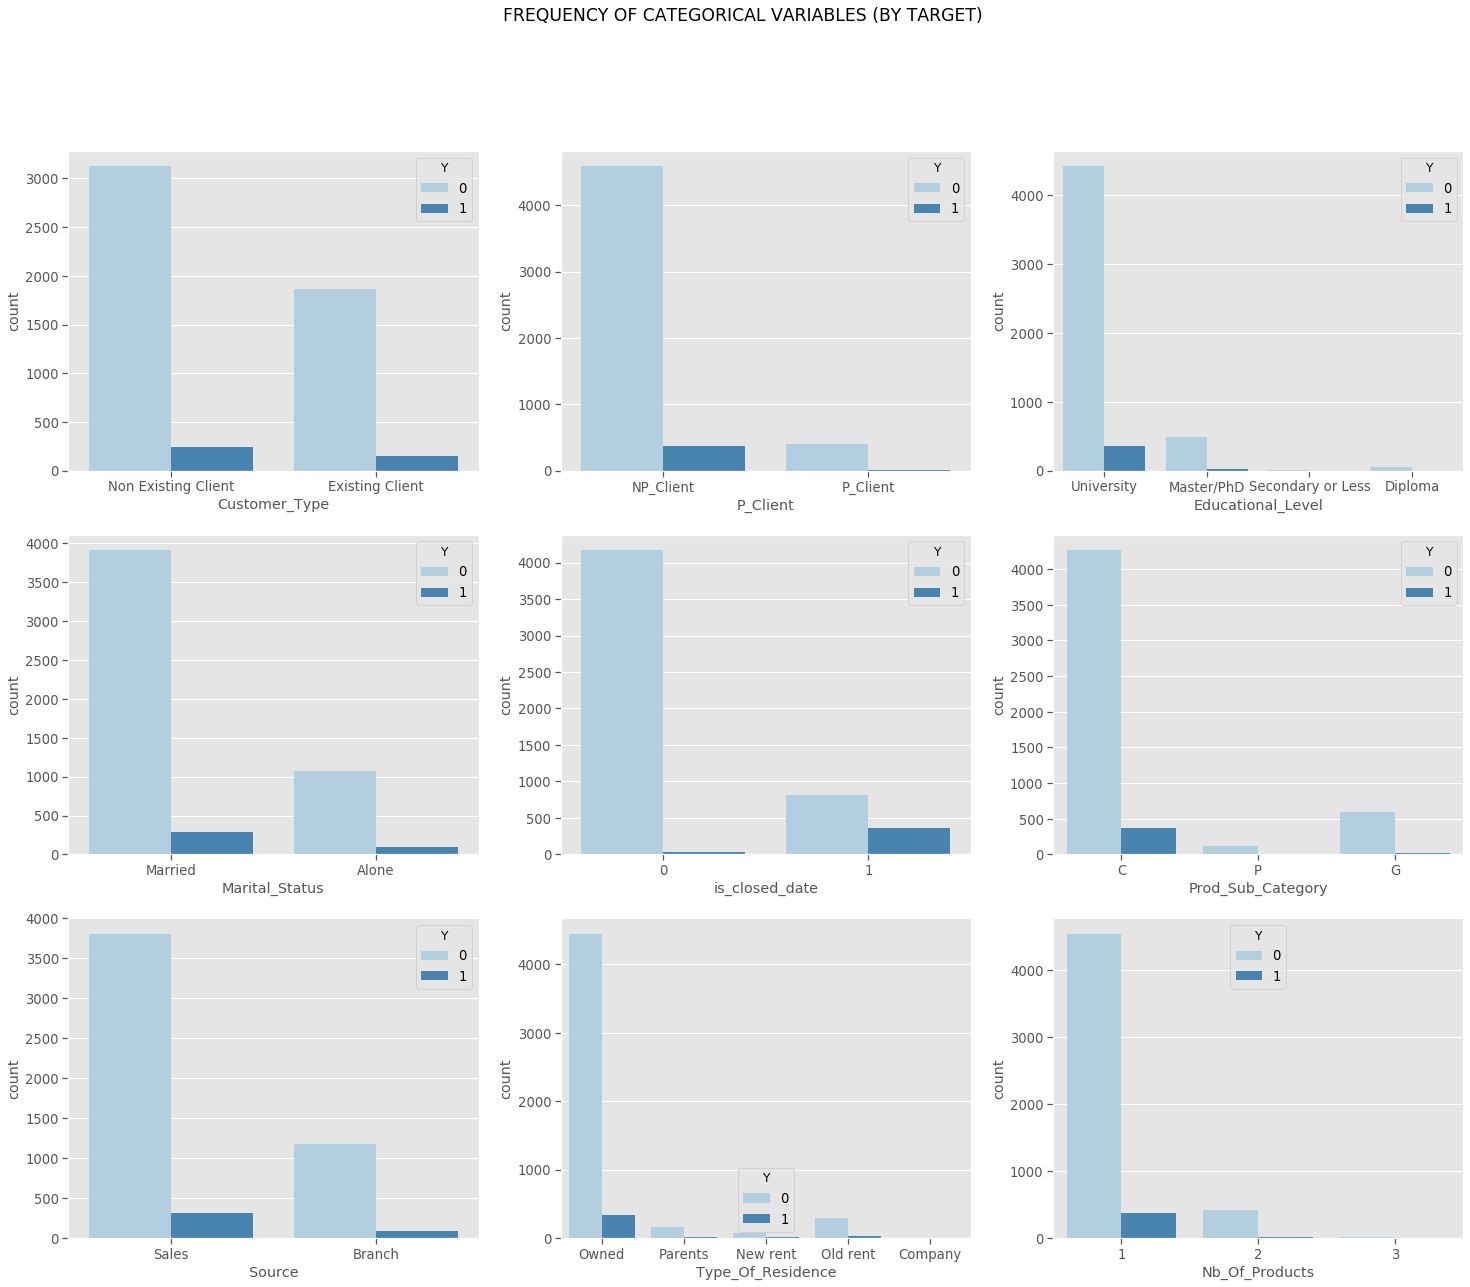

In [10]:
subset = data[['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status', 'Number_Of_Dependant',  'Prod_Sub_Category',"Source","Type_Of_Residence","Nb_Of_Products","is_closed_date","Y"]]

f, axes = plt.subplots(3, 3, figsize=(25, 20), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')

ax1 = sns.countplot(x="Customer_Type", hue="Y", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="P_Client", hue="Y", data=subset, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="Educational_Level", hue="Y", data=subset, palette="Blues", ax=axes[0,2])
ax4 = sns.countplot(x="Marital_Status", hue="Y", data=subset, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="is_closed_date", hue="Y", data=subset, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="Prod_Sub_Category", hue="Y", data=subset, palette="Blues", ax=axes[1,2])
ax7 = sns.countplot(x="Source", hue="Y", data=subset, palette="Blues", ax=axes[2,0])
ax8 = sns.countplot(x="Type_Of_Residence", hue="Y", data=subset, palette="Blues", ax=axes[2,1])
ax9= sns.countplot(x="Nb_Of_Products", hue="Y", data=subset, palette="Blues", ax=axes[2,2])




The customer category type **"P_client"** is an important factor in discriminating those who are most likely to default. 
<br>
We also notice that individuals with an **"is_closed_date"** of the product are more likely to default than those who do not. 
<br>
Moreover the fact that he is in a **"Marital_status"** couple gives him more chance to default than if he was not. 

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id_Customer,5380.0,4784.54,2781.44,1.0,2368.5,4762.5,7180.25,9605.0
Y,5380.0,0.07,0.26,0.0,0.0,0.0,0.00,1.0
Number_Of_Dependant,5378.0,1.06,1.34,0.0,0.0,0.0,2.00,20.0
Years_At_Residence,5380.0,12.63,9.97,0.0,4.0,10.0,18.00,70.0
Net_Annual_Income,5378.0,61.13,237.75,0.0,20.0,36.0,36.00,10000.0
Years_At_Business,5378.0,4.27,7.23,0.0,1.0,1.0,4.00,98.0
Nb_Of_Products,5380.0,1.09,0.30,1.0,1.0,1.0,1.00,3.0
join_age,5380.0,38.36,10.94,1.0,29.0,37.0,47.00,65.0
sub_delay,5380.0,458.28,1135.98,0.0,2.0,7.0,304.25,10944.0
is_closed_date,5380.0,0.22,0.41,0.0,0.0,0.0,0.00,1.0


/home/maza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


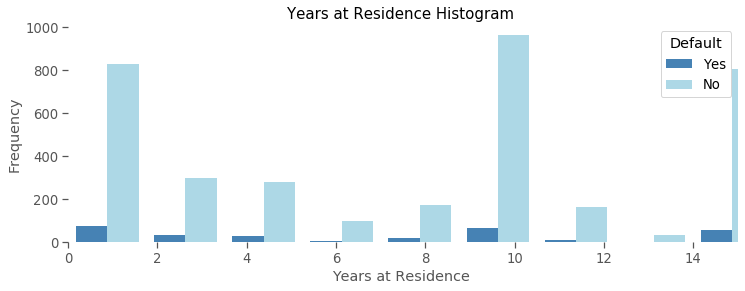

In [15]:
x1 = list(data[data['Y'] == 1]['Years_At_Residence'])
x2 = list(data[data['Y'] == 0]['Years_At_Residence'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, normed=False, color=['steelblue', 'lightblue'])
plt.xlim([0,15])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Years at Residence ')
plt.ylabel('Frequency')
plt.title('Years at Residence Histogram ', SIZE=15)
plt.box(False)

/home/maza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


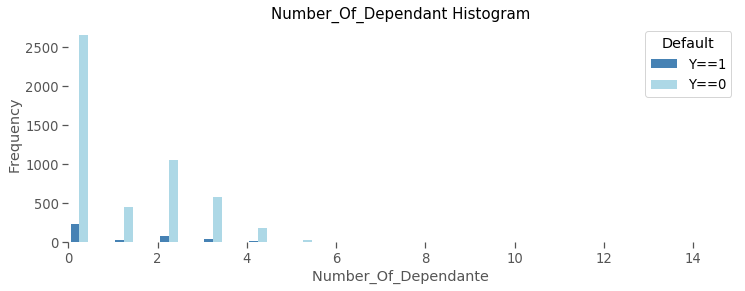

In [16]:
x1 = list(data[data['Y'] == 1]['Number_Of_Dependant'])
x2 = list(data[data['Y'] == 0]['Number_Of_Dependant'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, normed=False, color=['steelblue', 'lightblue'])
plt.xlim([0,15])
plt.legend(['Y==1', 'Y==0'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Number_Of_Dependante ')
plt.ylabel('Frequency')
plt.title('Number_Of_Dependant Histogram ', SIZE=15)
plt.box(False)

Text(0.5, 1.0, 'Distribution of Ages')

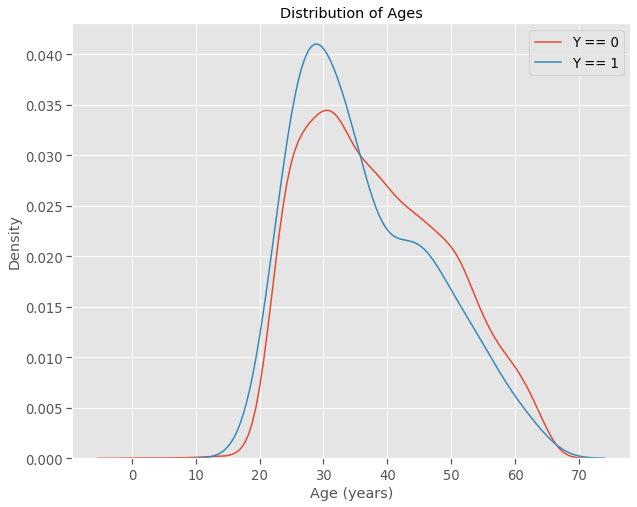

In [17]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['Y'] == 0, 'join_age'], label = 'Y == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['Y'] == 1, 'join_age'] , label = 'Y == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.show()

* Client which age his between " 20-35" have more chance to default . We remplace by bins and then encode each age by his range mean value (**mean_age**) . 

In [18]:
data['YEARS_BINNED'] = pd.cut(data['join_age'], bins = [0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
age_data=data[["join_age","YEARS_BINNED","Y"]]
#Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups=age_groups.rename(columns={"join_age": "mean_age"})
age_groups=age_groups.drop("Y",axis=1)

data = pd.merge(data,age_groups,on = 'YEARS_BINNED',how = 'left')


### New Features 


In this part, we build new features that we think are relevant to determine whether a client will fail. These include :


**"bussiness_salaries"**: ratio between his annual salary and the number of years of service . We say that the closer the customer is to retirement (maximum years of work) and that he has a small salary the more he will be unable to pay his credit. 

**"Nb_salaries"** : his annual salary on the number of products contracted . The more products he has, the more difficult it will be for him to repay. 

**"money_by_person"**: his salary on number of dependants. 


In [19]:
data["bussiness_salaries"]=data["Net_Annual_Income"].astype("float")/(1+data["Years_At_Business"].values)

## change all status different to married to "Single"
data["Marital_Status"]=np.where((data["Marital_Status"]!="Married"),"Alone",data["Marital_Status"])

## Income divide by Nb_Poject

data["Nb_salaries"]=data["Net_Annual_Income"].astype("float")/(1+data["Nb_Of_Products"].values)

##dependance divide by num of year in business

data["money_by_person"]=data["Net_Annual_Income"]/(1+data["Number_Of_Dependant"])


In [20]:
colums_to_drop=["Customer_Open_Date",'join_age',"mean_age",'YEARS_BINNED', 'BirthDate', 'Id_Customer', 'Prod_Decision_Date', 'Prod_Closed_Date']

data = data.drop(colums_to_drop, axis=1)
data = data.dropna()



In [21]:
data.tail(10)

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,sub_delay,is_closed_date,bussiness_salaries,Nb_salaries,money_by_person
5370,0,Existing Client,NP_Client,University,Married,0.0,15,36.0,1.0,C,Sales,Owned,1,B,2120,0,18.00,18.0,36.0
5371,1,Existing Client,NP_Client,Master/PhD,Alone,0.0,15,50.0,7.0,G,Sales,Owned,1,C,29,1,6.25,25.0,50.0
5372,0,Non Existing Client,NP_Client,University,Married,0.0,11,36.0,3.0,C,Sales,Owned,1,B,3,0,9.00,18.0,36.0
5373,0,Existing Client,NP_Client,University,Married,3.0,20,50.0,1.0,C,Sales,Owned,1,L,7,0,25.00,25.0,12.5
5374,0,Non Existing Client,NP_Client,University,Married,0.0,1,20.0,1.0,C,Sales,Owned,1,B,3,0,10.00,10.0,20.0
5375,0,Non Existing Client,NP_Client,University,Married,2.0,1,36.0,1.0,G,Sales,Owned,1,C,37,0,18.00,18.0,12.0
5376,1,Existing Client,NP_Client,University,Married,3.0,15,24.0,1.0,C,Sales,Owned,1,L,19,1,12.00,12.0,6.0
5377,0,Non Existing Client,NP_Client,University,Alone,0.0,14,14.0,30.0,C,Branch,Old rent,1,B,1,1,0.45,7.0,14.0
5378,0,Non Existing Client,NP_Client,University,Married,1.0,1,36.0,1.0,G,Sales,Owned,1,C,4,0,18.00,18.0,18.0
5379,0,Non Existing Client,NP_Client,University,Married,0.0,15,30.0,1.0,C,Sales,Owned,1,B,8,0,15.00,15.0,30.0


## Features importances

We will use the LGBM model to evaluate the relevance of our features in determining the prediction. 


In [22]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [23]:
df = data.dropna()
categ_names=["Customer_Type","P_Client","Educational_Level","Marital_Status","Prod_Sub_Category","Source","Type_Of_Residence","Prod_Category"]
for cname in categ_names:
    df[cname] = df[cname].astype('category')
    
y = df.Y
X = df.drop("Y", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [24]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [25]:
params = {
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}
evals_result = {}  # to record eval results for plotting
cc = ['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status',
       'Number_Of_Dependant', 'Years_At_Residence', 'Net_Annual_Income', 'Years_At_Business',
       'Prod_Sub_Category', 'Source', 'Type_Of_Residence', 'Nb_Of_Products', 'Prod_Category',
      'sub_delay', 'is_closed_date', 'bussiness_salaries', 'money_by_person',"Nb_salaries"]

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=cc,
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)

[10]	training's l1: 0.103161	training's l2: 0.045692	valid_1's l1: 0.1019	valid_1's l2: 0.0467959
[20]	training's l1: 0.0916362	training's l2: 0.0421557	valid_1's l1: 0.0912357	valid_1's l2: 0.044042
[30]	training's l1: 0.0873944	training's l2: 0.0409559	valid_1's l1: 0.0879727	valid_1's l2: 0.0434251
[40]	training's l1: 0.085708	training's l2: 0.0403268	valid_1's l1: 0.0869328	valid_1's l2: 0.043414
[50]	training's l1: 0.0846873	training's l2: 0.0398974	valid_1's l1: 0.086433	valid_1's l2: 0.0434243
[60]	training's l1: 0.0843531	training's l2: 0.0395953	valid_1's l1: 0.0864684	valid_1's l2: 0.0435464
[70]	training's l1: 0.0841547	training's l2: 0.0393177	valid_1's l1: 0.0865617	valid_1's l2: 0.0435779
[80]	training's l1: 0.0839245	training's l2: 0.0390583	valid_1's l1: 0.0866614	valid_1's l2: 0.0435736
[90]	training's l1: 0.0838662	training's l2: 0.0387688	valid_1's l1: 0.0870988	valid_1's l2: 0.0436285
[100]	training's l1: 0.0837582	training's l2: 0.0384927	valid_1's l1: 0.087266	val

/home/maza/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [26]:
try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    
    
    
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()
    
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])
    
    
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=3):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

interactive(children=(Dropdown(description='metric_name', options=('l1', 'l2'), value='l1'), Output()), _dom_c…

In [27]:
if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, X_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

interactive(children=(Dropdown(description='importance_type', options=('split', 'gain'), value='split'), IntSl…

## Conclusion

Features importances show that the new features are **relevants**, so we will use them in training our models to predict credit default.